In [10]:
import sys
import os

sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))

import numpy as np
import torch
from torch import nn
import math

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager, particles
from visualization import levels_plot, transitions_plot, spin_system_plot
from population import time_population, tr_utils, transform
import population

from importlib import reload

from spectra_manager import TruncatedSpectraCreatorTimeResolved, PostSpectraProcessing,TimeResolvedIntensitiesCalculator, ParamSpec
from spectral_integration import SpectraIntegratorEasySpinLikeTimeResolved, BaseSpectraIntegrator
from reader import read_bruker_data
from spectra_manager import BaseSpectraCreator

import optimization
import spectra_processing

import save_procedures

reload(spectral_integration)
reload(spin_system)
reload(population)
reload(population.stationary_population)
reload(optimization.fitter)
reload(optimization.objectives)
reload(optimization.interactions)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimization)

reload(mesher)
reload(mesher.delanay_neigbour)
reload(mesher.general_mesh)

reload(mesher.torch_tps)
from mesher.torch_tps import thin_plate_spline, polynomial_transform

reload(thin_plate_spline)
reload(polynomial_transform)
reload(mesher.torch_tps)

reload(spin_system_plot)
reload(save_procedures)

<module 'save_procedures' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\save_procedures.py'>

In [11]:
constants.unit_converter(1, "cm-1_to_Hz") / 1e10

2.99792458

In [12]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=50,
                                    interpolate=True, interpolation_grid_frequency=100)

In [13]:
e_1 = particles.Electron(spin=1.5)
g_1 = spin_system.Interaction((2.1, 2.2, 2.3))

D = 260 * 1e6
E = 50 * 1e6

zer = spin_system.DEInteraction((D, E))

system = spin_system.SpinSystem([e_1, ], g_tensors=(g_1,), electron_electron=[(0, 0, zer)])
sample = spin_system.MultiOrientedSample(system, ham_strain=(2e8, 2e8, 2e8), lorentz=0.01, gauss=0.01)

fields_1 = torch.linspace(0.9, 1.5, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp, mesh=mesh)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

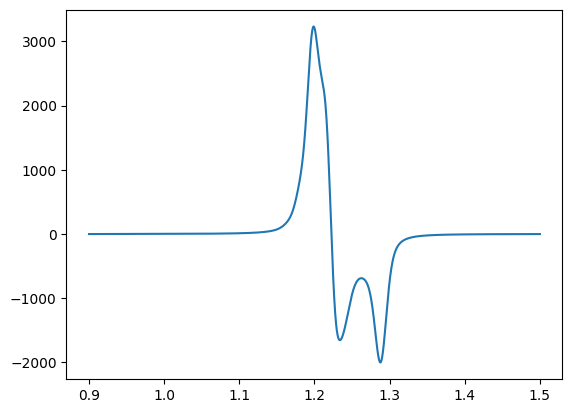

In [14]:
plt.plot(fields_1.numpy(), spec_1.numpy())

In [6]:
e_1 = particles.Electron(spin=0.5)
e_2 = particles.Electron(spin=1.5)
g_1 = spin_system.Interaction((2.1, 2.2, 2.3))
g_2 = spin_system.Interaction((2.1, 2.1, 2.1))

J = constants.unit_converter(0, "cm-1_to_Hz")
D = 260 * 1e6
E = 50 * 1e6

ee = spin_system.Interaction(J) + spin_system.DEInteraction((D, E))
zer = spin_system.DEInteraction((D, E))


system = spin_system.SpinSystem([e_1, e_2], g_tensors=(g_1, g_2), electron_electron=[(0, 1, ee), (1, 1, zer)])
sample = spin_system.MultiOrientedSample(system, ham_strain=(2e8, 2e8, 2e8), lorentz=0.01, gauss=0.01)

fields_1 = torch.linspace(1.1, 1.4, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp, mesh=mesh)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

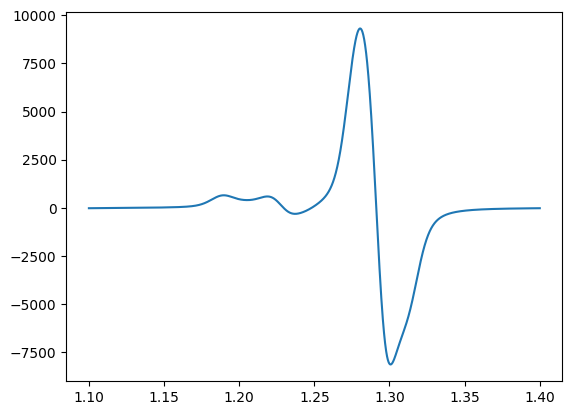

In [7]:
plt.plot(fields_1.numpy(), spec_1.numpy())

In [267]:
import pandas as pd

data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")


In [45]:
param_space = optimization.SampleVary().vary(sample,
                               g_tensors=(
                                   (0, optimization.VaryInteraction((0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1))),
                               )
                              )

In [117]:
def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, g1_frame)
        
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor)
        
        g_cu_branching = torch.tensor(g_cu_branching)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching, orient_up)
        zeem_branching = spin_system.Interaction(g_cu_branching)
        
        e_chain = particles.Electron(spin=0.5)
        e_branching = particles.Electron(spin=0.5)
        
        J = J # Because 2 S1 S2
        J = (J * 100) * 3 * 1e8
        J = torch.full((3,), J)
        d_frame = torch.zeros(3)
        ee_int_chain = spin_system.Interaction(J, d_frame)
        
        system = spin_system.SpinSystem(
            electrons=[e_chain, e_branching],
            g_tensors=[zeem_chain, zeem_branching],
            electron_electron=[
                (0, 1, ee_int_chain)
            ]
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([1e9, 1e9, 1e9]), gauss, lorentz, mesh)

In [118]:
orien_side_up = torch.tensor(
    [
        [0.8859114, 0.0008034, 0.4638538],
        [0.0005397, -0.9999996, 0.0007013],
        [0.4638541, -0.000371, -0.8859115],]
)

orien_chain_left = torch.tensor(
    [
        [0.744169, 0.4552341, -0.4888501],
        [0.3236334, -0.8859029, -0.3323212],
        [-0.5843577, 0.0890949, -0.8065904]
    ]
)


J = -0.0
g_cu_chain = [2.1, 2.2, 2.3]
g_cu_branching = [2.2, 2.2, 2.2]
gauss = torch.tensor(0.0001)
lorentz = torch.tensor(0.01)
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=30,
                                    interpolate=True, interpolation_grid_frequency=60)


system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)


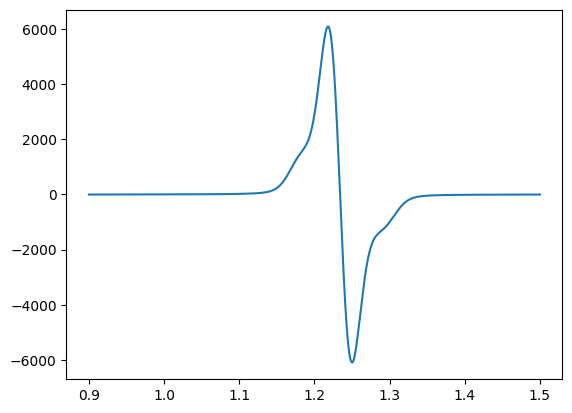

In [119]:
fields_1 = torch.linspace(0.9, 1.5, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

In [120]:
import pandas as pd
fields_1 = fields_1.numpy()
spec_1 = spec_1.numpy()


data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")

### dipole-dipole

In [64]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=15,
                                    interpolate=False, interpolation_grid_frequency=70)

def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, g1_frame)
        
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor)
        
        g_cu_branching = torch.tensor(g_cu_branching)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching)
        zeem_branching = spin_system.Interaction(g_cu_branching)
        
        e_chain = particles.Electron(spin=0.5)
        e_branching = particles.Electron(spin=0.5)
        
        D, E = constants.unit_converter(0.1, "cm-1_to_Hz"), constants.unit_converter(0.003, "cm-1_to_Hz")
        J = J # Because 2 S1 S2
        J = (J * 100) * 3 * 1e8
        ee_int_chain = spin_system.Interaction(J) + spin_system.DEInteraction((D, E))
        print(ee_int_chain)
        
        system = spin_system.SpinSystem(
            electrons=[e_chain, e_branching],
            g_tensors=[zeem_chain, zeem_branching],
            electron_electron=[
                (0, 1, ee_int_chain)
            ]
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([5e7, 5e7, 5e7]), gauss, lorentz, mesh)

In [65]:
system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)

Principal values: [-9.09e+08, -1.09e+09, 2.00e+09]
Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
Strain: None


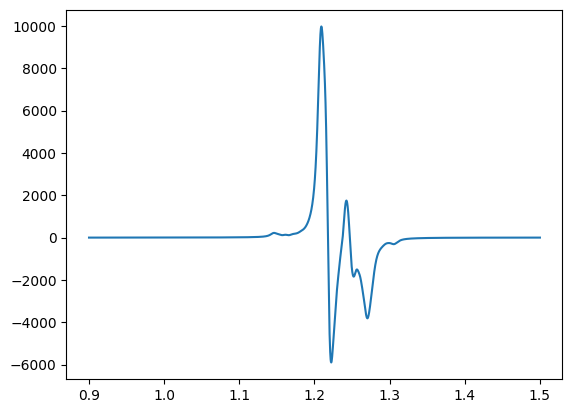

In [66]:
fields_1 = torch.linspace(0.9, 1.5, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

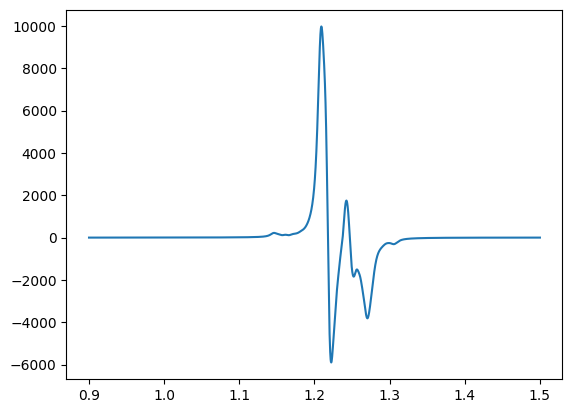

In [67]:
fields_1 = torch.linspace(0.9, 1.5, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

In [68]:
import pandas as pd
fields_1 = fields_1.numpy()
spec_1 = spec_1.numpy()


data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")

(0, 1)


### D-E interaction

In [548]:
reload(spectral_integration)
reload(spin_system)
reload(population)
reload(population.stationary_population)
reload(optimization.fitter)
reload(optimization.objectives)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimization)
reload(mesher.general_mesh)
reload(mesher)
reload(mesher.delanay_neigbour)


reload(spin_system_plot)
reload(save_procedures)

<module 'save_procedures' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\save_procedures.py'>

In [549]:
def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, g1_frame)
        
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor)
        
        g_cu_branching = torch.tensor(g_cu_branching)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching)
        zeem_branching = spin_system.Interaction(g_cu_branching)
        
        e_chain = particles.Electron(spin=1.0)
        e_branching = particles.Electron(spin=0.5)
        
        D, E = constants.unit_converter(0.1, "cm-1_to_Hz"), constants.unit_converter(0.0003, "cm-1_to_Hz")

        ee_int_chain = spin_system.DEInteraction((D, E), strain=(0.0, 0))
        
        system = spin_system.SpinSystem(
            electrons=[e_chain, e_branching],
            g_tensors=[zeem_chain, zeem_branching],
            electron_electron=[
                (0, 0, ee_int_chain)
            ]
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([5e7, 5e7, 5e7]), gauss, lorentz, mesh)

In [558]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=20,
                                    interpolate=True, interpolation_grid_frequency=25)

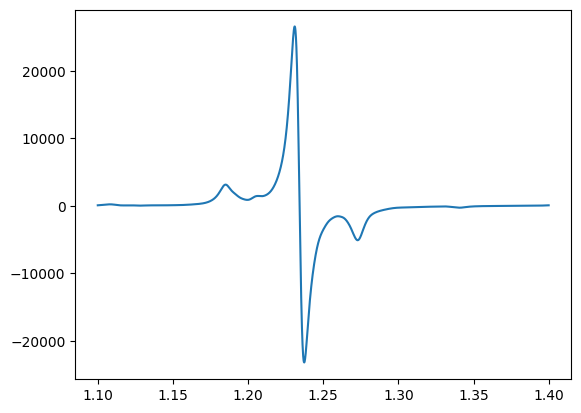

In [559]:
system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)

fields_1 = torch.linspace(1.1, 1.40, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

In [303]:
import pandas as pd
fields_1 = fields_1.numpy()
spec_1 = spec_1.numpy()


data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")

[[2.99792467e+09 8.99376000e+06]
 [0.00000000e+00 0.00000000e+00]]


### Nuclei

In [304]:
def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, g1_frame)
        
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor)
        
        g_cu_branching = torch.tensor(g_cu_branching)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching)
        zeem_branching = spin_system.Interaction(g_cu_branching)
        
        e_chain = particles.Electron(spin=1.0)
        e_branching = particles.Electron(spin=0.5)
        A_interaction = spin_system.Interaction((1e7, 1e7, 1e9))

        
        system = spin_system.SpinSystem(
            electrons=[e_chain, e_branching],
            nuclei = ["14N", "14N"],
            g_tensors=[zeem_chain, zeem_branching],
            electron_nuclei=[(0, 0, A_interaction), (1, 0, A_interaction), (1, 1, A_interaction)]
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([5e7, 5e7, 5e7]), gauss, lorentz, mesh)

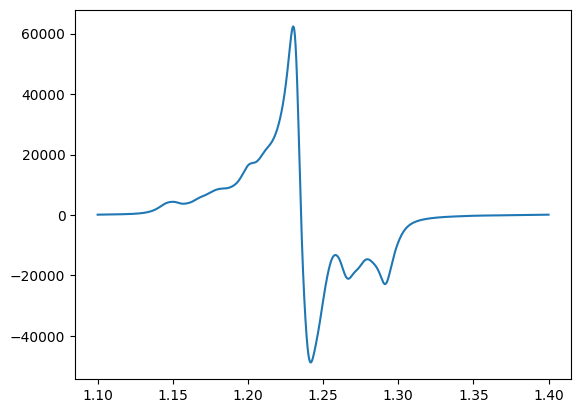

In [305]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=10, 
                                    interpolate=True, interpolation_grid_frequency=30)

system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)

fields_1 = torch.linspace(1.1, 1.40, 3000)
freq = torch.tensor(38 * 1e9)
temp = 1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)

plt.plot(fields_1.numpy(), spec_1.numpy())

In [ ]:
import pandas as pd
fields_1 = fields_1.numpy()
spec_1 = spec_1.numpy()


data_frame = pd.DataFrame({"field": fields_1, "spec": spec_1})
data_frame.to_csv("D:\ITC\РНФ_Курганский_2024\qulity_spectra.csv", header=False, index=False)
save_procedures.save("D:\ITC\РНФ_Курганский_2024\example.mat", sample, spec_creat, fields_1, format_type="easyspin")

In [24]:
reload(spectral_integration)
reload(spin_system)
reload(population)
reload(population.stationary_population)
reload(optimization.fitter)
reload(optimization.objectives)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimization)
reload(mesher.general_mesh)
reload(mesher)
reload(mesher.delanay_neigbour)


reload(spin_system_plot)
reload(save_procedures)

<module 'save_procedures' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\save_procedures.py'>

In [139]:
out = save_procedures.load("D:\ITC\РНФ_Курганский_2024\example.mat", format_type="easyspin")

In [140]:
sample = out["sample"]

In [142]:
print(sample)

SPIN SYSTEM SUMMARY

PARTICLES:
--------------------
Electrons (2):
  e0: S=1.0 
Principal values: [2.1000, 2.2000, 2.3000]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  e1: S=0.5 
Principal values: [2.2000, 2.2000, 2.2000]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None

Nuclei (2):
  n0: I=1.0
  n1: I=1.0

SYSTEM PROPERTIES:
--------------------
Hilbert space dimension: 54
Configuration shape: ()

INTERACTIONS (5 total):
------------------------------

Electron-Nucleus (4):
  1. e0 ↔ n0:
      Principal values: [1.00e+07, 1.00e+07, 1.00e+09]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  2. e0 ↔ n1:
      Principal values: [1.00e+07, 1.00e+07, 1.00e+09]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  3. e1 ↔ n0:
      Principal values: [1.00e+07, 1.00e+07, 1.00e+09]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  4. e1 ↔